<a href="https://colab.research.google.com/github/hyunholee26/Short-term-water-level-prediction-in-the-river-using-LSTM-with-MC-dropout/blob/main/collect_data/%5Bwlp%5D_3_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from urllib.request import Request, urlopen, build_opener, HTTPRedirectHandler, addinfourl
from urllib.parse import urlencode, quote_plus

from bs4 import BeautifulSoup

import json

import datetime
import os
import glob

In [ ]:
path = '/content/drive/MyDrive/data/flood/'

raw_period = {'startdt': ['20140101', '20140701', '20150101', '20150701', '20160101', '20160701', '20170101', '20170701', '20180101', '20180701', '20190101', '20190701', '20200101', '20200701', '20210101'],
                'enddt': ['20140630', '20141231', '20150630', '20151231', '20160630', '20161231', '20170630', '20171231', '20180630', '20181231', '20190630', '20191231', '20200630', '20201231', '20210630']}

df_period = pd.DataFrame(raw_period)
df_period

,startdt,enddt
0,20140101,20140630
1,20140701,20141231
2,20150101,20150630
3,20150701,20151231
4,20160101,20160630
5,20160701,20161231
6,20170101,20170630
7,20170701,20171231
8,20180101,20180630
9,20180701,20181231


In [ ]:
# eda for water level
class NoRedirectHandler(HTTPRedirectHandler):
    def http_error_302(self, req, fp, code, msg, headers):
        infourl = addinfourl(fp, headers, req.get_full_url())
        infourl.status = code
        infourl.code = code
        print('exception')
        raise Exception('redirection')
        return infourl
    http_error_300 = http_error_302
    http_error_301 = http_error_302
    http_error_303 = http_error_302
    http_error_307 = http_error_302

def water_level_eda(obscd, type, from_api = True) :
  if type == 'wl':
    url = 'http://www.wamis.go.kr:8080/wamis/openapi/wkw/wl_hrdata'
  elif type == 'rf':
    url = 'http://www.wamis.go.kr:8080/wamis/openapi/wkw/rf_hrdata'
  else:
    print('Wrong type, check source code again!')
    return None
  df_temp = pd.DataFrame()
  #obscd = '1018630'

  # set period key
  start = datetime.datetime.strptime("2014010101", "%Y%m%d%H")
  end = datetime.datetime.strptime("2021063023", "%Y%m%d%H")
  date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]
  df = pd.DataFrame(date_generated, columns =['Date'])
  df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 

  # get data through openapi
  if from_api == True:
    for j, row_j in df_period.iterrows():
      startdt = row_j['startdt'] 
      enddt = row_j['enddt'] 
      queryParams = '?' + urlencode({ quote_plus('key') : '36c9f67744f056ef568d114e3f9187aadda8173c82', quote_plus('obscd') : str(obscd), quote_plus('startdt') : str(startdt), quote_plus('enddt') : str(enddt), quote_plus('output') : 'json' })
      request = Request(url + queryParams)
      request.get_method = lambda: 'GET'
      opener = build_opener(NoRedirectHandler())
      
      trycount = 10 # retry counter 
      while trycount > 0 :
        try:
          response_body = opener.open(request).read().decode('utf-8')
          break;
        except:
          trycount = trycount - 1
          continue;
      #response_body = urlopen(request).read().decode('utf-8')
      if trycount > 0:
        #print(response_body)
        jj = json.loads(response_body)
        df_temp = pd.json_normalize(jj['list'])
        filename = type + '_' + str(obscd) + '_' + str(startdt) + '_' + str(enddt) + '.csv'
        df_temp.to_csv(path + filename, index=False)
        print('Complete:' + path + filename)

  # merge files
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  return df

exception
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20180101_20180630.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018630_20200101_20200

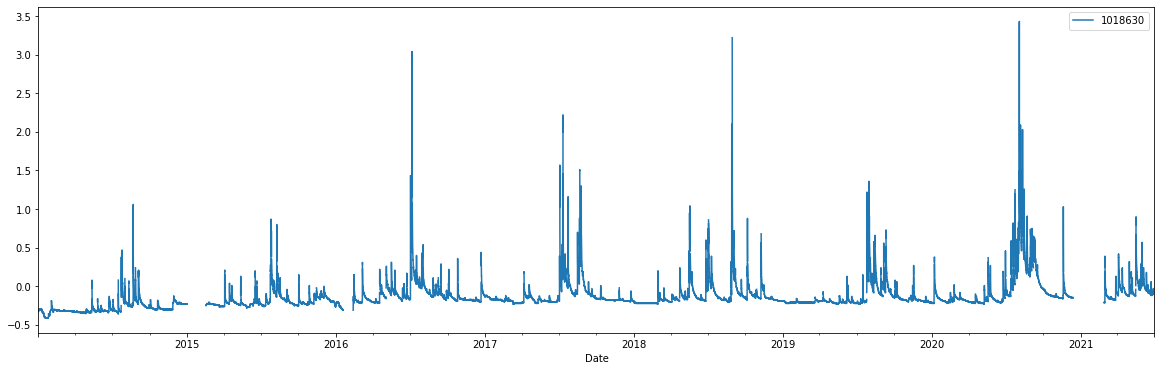

In [ ]:
# 남양주 진관교 : 1018630, 주의보: 2, 경보: 3
df_1018630 = water_level_eda(obscd = '1018630', type = 'wl')
df_temp = df_1018630.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20150101_20150630.csv
exception
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20170101_20170630.csv
exception
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184110_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/rf_

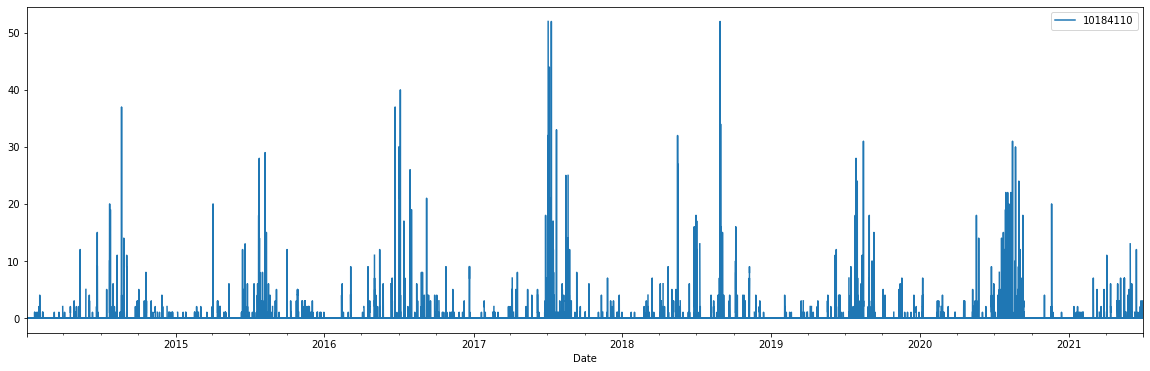

In [ ]:
# 남양주 진관교 : 10184110, 강수량 시간데이터
df_10184110 = water_level_eda(obscd = '10184110', type = 'rf')
df_temp = df_10184110.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20170101_20170630.csv
exception
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/rf_10184220_2

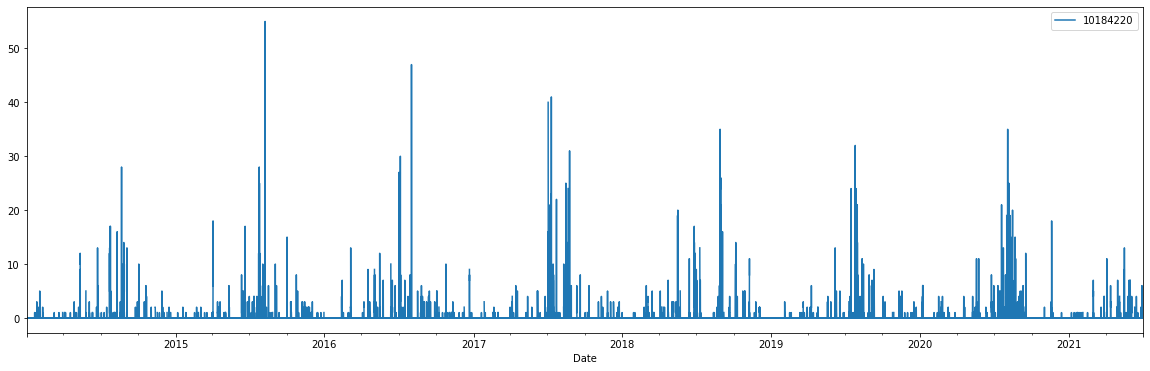

In [ ]:
# 남양주 진접읍사무소 : 10184220, 강수량 시간데이터
df_10184110 = water_level_eda(obscd = '10184220', type = 'rf')
df_temp = df_10184110.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

In [ ]:
df_10184110

,Date,ymdh,10184110
0,2014-01-01 01:00:00,2014010101,0.0
1,2014-01-01 02:00:00,2014010102,0.0
2,2014-01-01 03:00:00,2014010103,0.0
3,2014-01-01 04:00:00,2014010104,0.0
4,2014-01-01 05:00:00,2014010105,0.0
...,...,...,...
65706,2021-06-30 19:00:00,2021063019,0.0
65707,2021-06-30 20:00:00,2021063020,0.0
65708,2021-06-30 21:00:00,2021063021,0.0
65709,2021-06-30 22:00:00,2021063022,0.0


exception
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20150701_20151231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20170701_20171231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3011665_20190701_20191231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_30

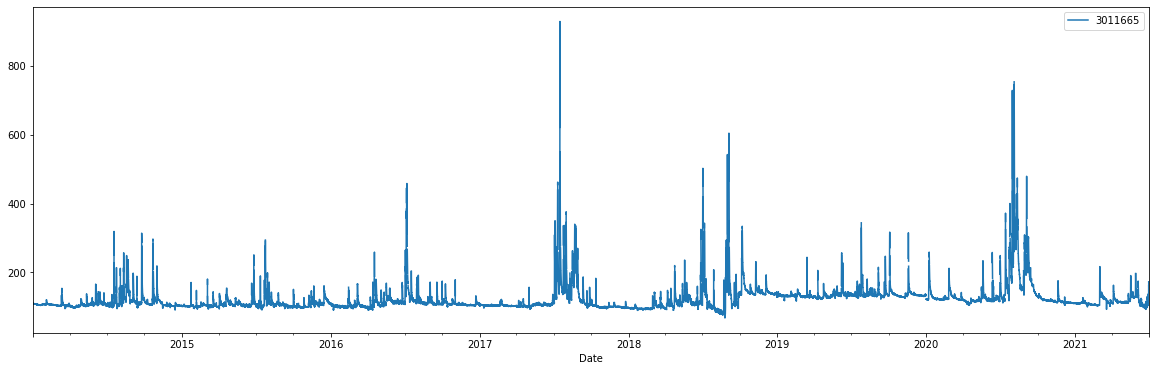

In [ ]:
# 청주 미호천교 : 3011665, 주의보: 7, 경보: 8
df_3011665 = water_level_eda(obscd = '3011665', type = 'wl')
df_temp = df_3011665.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20160701_20161231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1023660_20200101_20200

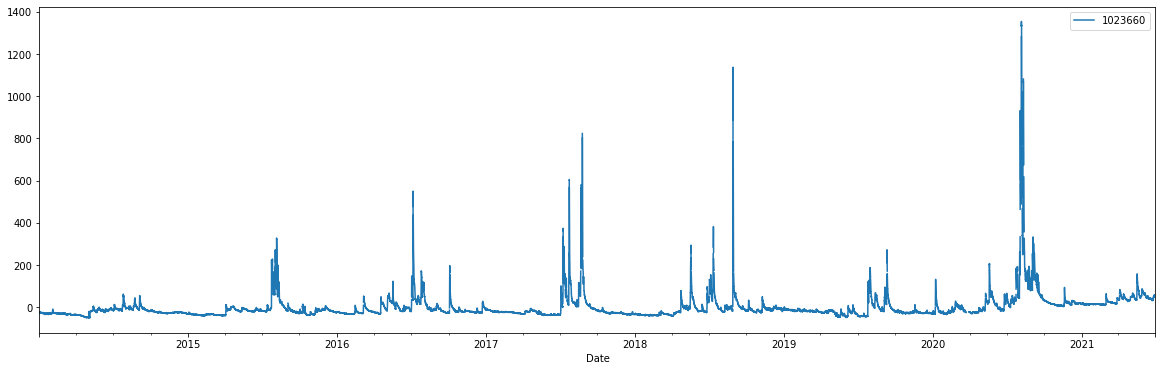

In [ ]:
# 파주 비룡대교 : 1023660, 주의보: 9.5, 경보: 11.5
df_1023660 = water_level_eda(obscd = '1023660', type = 'wl')
df_temp = df_1023660.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20150701_20151231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20170701_20171231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_4009610_20190701_20191231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_40

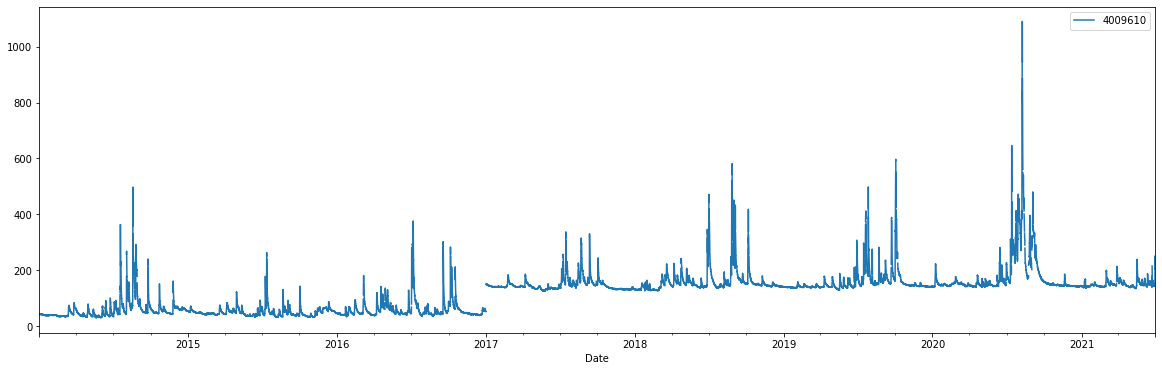

In [ ]:
# 구례군 구례교 : 4009610, 주의보: 7, 경보: 8
df_4009610 = water_level_eda(obscd = '4009610', type = 'wl')
df_temp = df_4009610.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20190101_20190630.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018675_20200101_20200

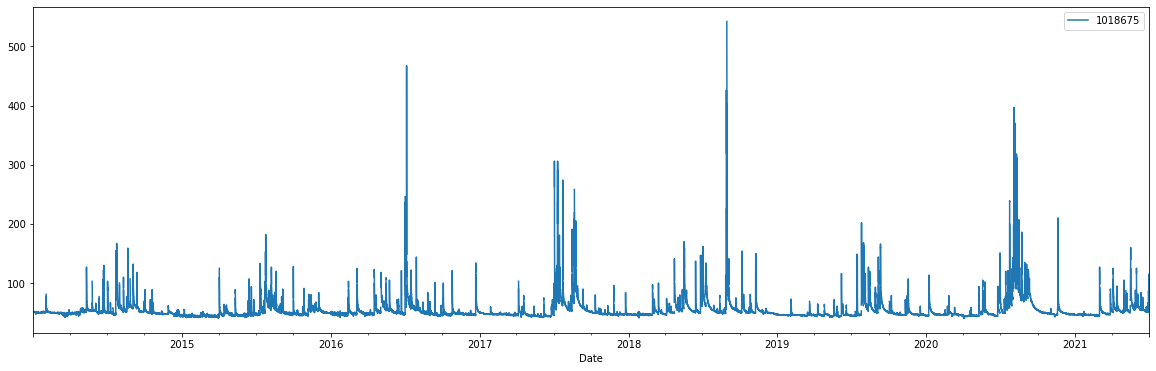

In [ ]:
# 서울시 중량교 : 1018675, 주의보: 5, 경보: 6.5
df_1018675 = water_level_eda(obscd = '1018675', type = 'wl')
df_temp = df_1018675.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20160701_20161231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1022680_20190701_20191231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1022680_2020

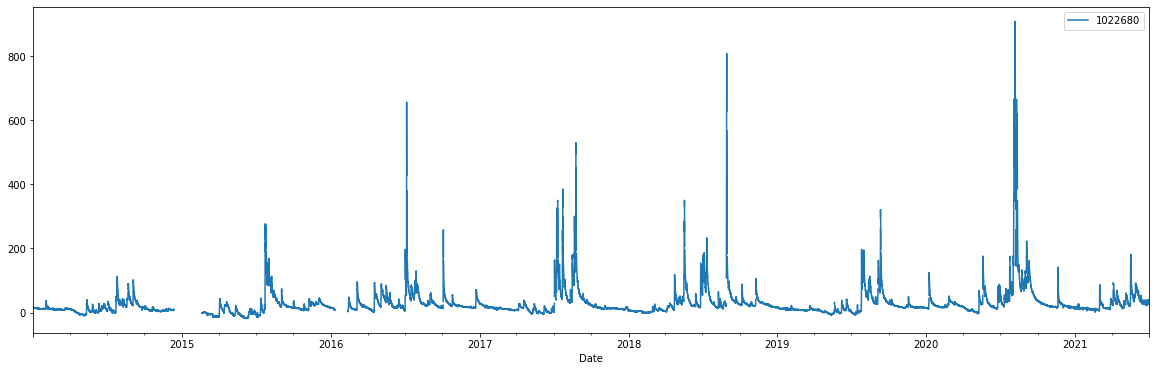

In [ ]:
# 연천군 사랑교 : 1022680, 주의보: 7.5, 경보: 9.5
df_1022680 = water_level_eda(obscd = '1022680', type = 'wl')
df_temp = df_1022680.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

Complete:/content/drive/MyDrive/data/flood/wl_3009680_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20160701_20161231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20190101_20190630.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_3009680_20200101_20200

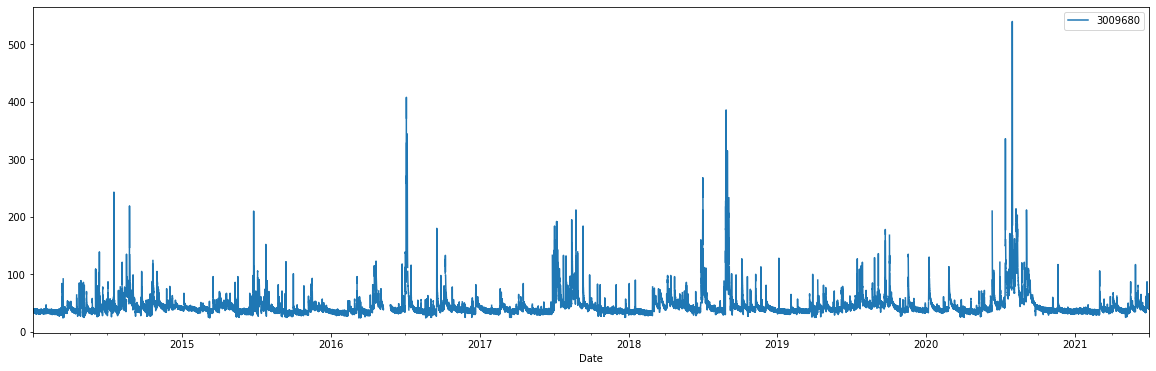

In [ ]:
# 대전 원촌교 : 3009680, 주의보: 4, 경보: 4.5
df_1022680 = water_level_eda(obscd = '3009680', type = 'wl')
df_temp = df_1022680.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20170701_20171231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018620_20200101_20200

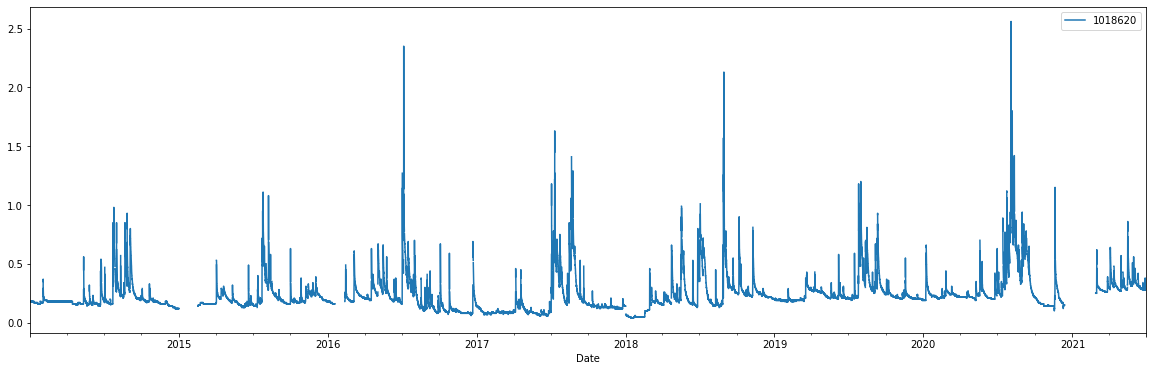

In [ ]:
# 남양주시 부평교 : 1018620
df_1018620 = water_level_eda(obscd = '1018620', type = 'wl')
df_temp = df_1018620.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

['/content/drive/MyDrive/data/flood/wl_1018623_20140101_20140630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20140701_20141231.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20150101_20150630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20150701_20151231.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20160101_20160630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20160701_20161231.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20170101_20170630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20170701_20171231.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20180101_20180630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20180701_20181231.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20190101_20190630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20190701_20191231.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20200101_20200630.csv', '/content/drive/MyDrive/data/flood/wl_1018623_20200701_20201231.csv', '/content/drive/MyD

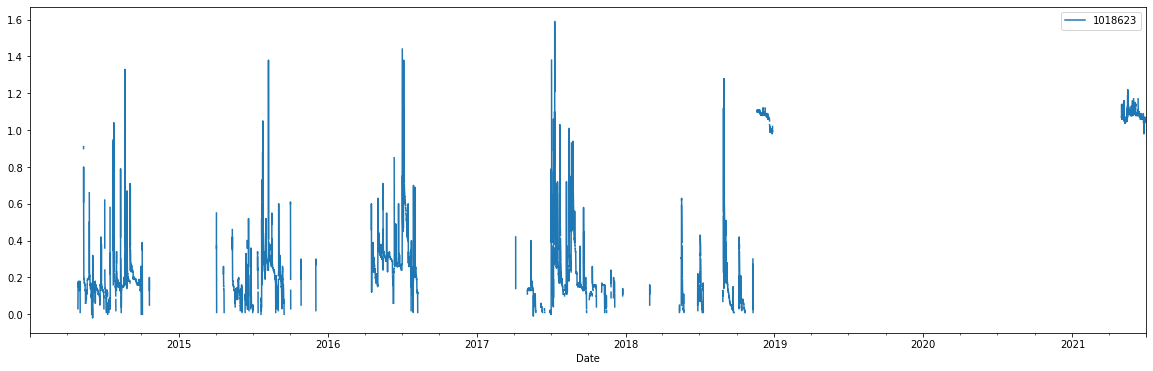

In [ ]:
# 남양주시 연평대교 : 1018623
df_1018623 = water_level_eda(obscd = '1018623', type = 'wl', from_api = False)
df_temp = df_1018623.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20170701_20171231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20180101_20180630.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018625_20200101_20200

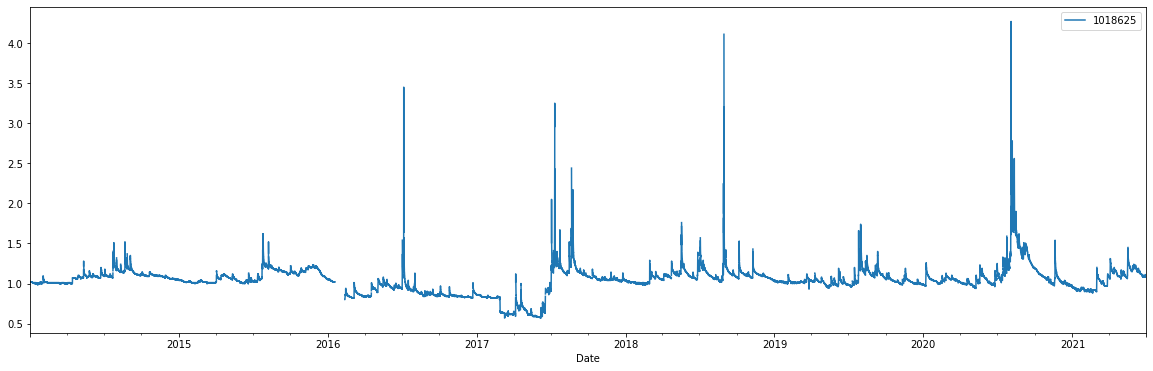

In [ ]:
# 남양주시 내곡교 : 1018625
df_1018625 = water_level_eda(obscd = '1018625', type = 'wl')
df_temp = df_1018625.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

exception
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20140101_20140630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20140701_20141231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20150101_20150630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20150701_20151231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20160101_20160630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20160701_20161231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20170101_20170630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20170701_20171231.csv
exception
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20180101_20180630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20180701_20181231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20190101_20190630.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20190701_20191231.csv
Complete:/content/drive/MyDrive/data/flood/wl_1018635_20200101_20200

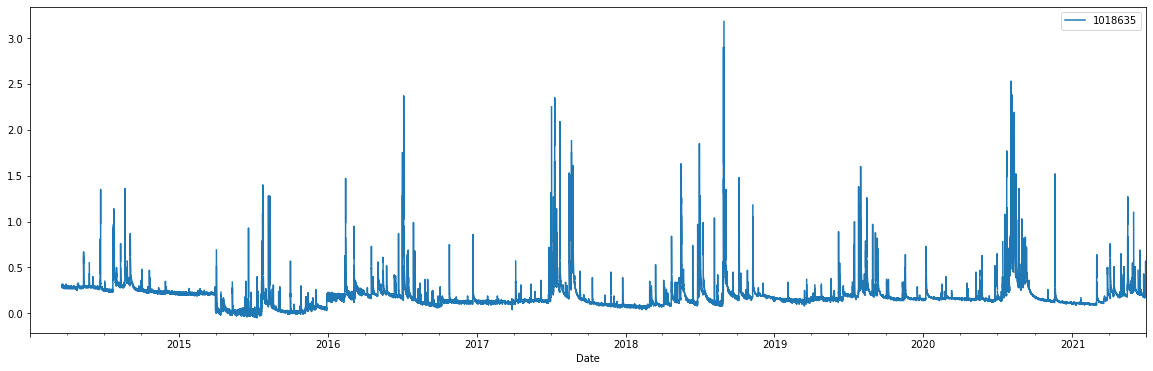

In [ ]:
# 남양주시 퇴계원리 : 1018635
df_1018635 = water_level_eda(obscd = '1018635', type = 'wl')
df_temp = df_1018635.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

In [ ]:
# 남양주시 왕숙교 : 1018638
df_1018638 = water_level_eda(obscd = '1018638', , type = 'wl', from_api = False)
df_temp = df_1018638a.drop(columns=['ymdh']).set_index('Date')
df_temp.plot(figsize=(20,6))

['/content/drive/MyDrive/data/flood/wl_1018638_20140101_20140630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20140701_20141231.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20150101_20150630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20150701_20151231.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20160101_20160630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20160701_20161231.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20170101_20170630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20170701_20171231.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20180101_20180630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20180701_20181231.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20190101_20190630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20190701_20191231.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20200101_20200630.csv', '/content/drive/MyDrive/data/flood/wl_1018638_20200701_20201231.csv', '/content/drive/MyD

UnboundLocalError: ignored

In [ ]:
raw_obscd = {'obscd': ['1018620', '1018623', '1018625', '1018630'],
            'desc': ['남양주시 부평교', '남양주시 연평대교', '남양주시 내곡교', '남양주시 진관교']}

df_obscd = pd.DataFrame(raw_obscd)
df_obscd

,obscd,desc
0,1018620,남양주시 부평교
1,1018623,남양주시 연평대교
2,1018625,남양주시 내곡교
3,1018630,남양주시 진관교


In [ ]:
start = datetime.datetime.strptime("2014010101", "%Y%m%d%H")
end = datetime.datetime.strptime("2021063023", "%Y%m%d%H")
date_generated = [start + datetime.timedelta(hours=x) for x in range(0, (end-start).days * 24 + 23)]

df = pd.DataFrame(date_generated, columns =['Date'])
df['ymdh'] = df['Date'].apply(lambda x: int(x.strftime('%Y%m%d%H'))) 
df

,Date,ymdh
0,2014-01-01 01:00:00,2014010101
1,2014-01-01 02:00:00,2014010102
2,2014-01-01 03:00:00,2014010103
3,2014-01-01 04:00:00,2014010104
4,2014-01-01 05:00:00,2014010105
...,...,...
65706,2021-06-30 19:00:00,2021063019
65707,2021-06-30 20:00:00,2021063020
65708,2021-06-30 21:00:00,2021063021
65709,2021-06-30 22:00:00,2021063022


In [ ]:
for i, row_i in df_obscd.iterrows():
  obscd = row_i['obscd']   
  
  files = glob.glob(path + '*' + obscd + '*.csv')
  files.sort()
  print(files)
  
  # Read files
  for index, file in enumerate(files):
    #print('Reading files ... : ' + file)
    try:
      if(index == 0):
        df_wl = pd.read_csv(file)
      else:
        temp = pd.read_csv(file)
        df_wl = df_wl.append(temp)
    except:
      print('Pass file : ' + file)
      continue
  df_wl.columns = ['ymdh', obscd]
  df = df.merge(df_wl, how='left', on = 'ymdh')
  #display(df)

['/content/drive/MyDrive/data/flood/wl_1018620_20140101_20140630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20140701_20141231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20150101_20150630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20150701_20151231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20160101_20160630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20160701_20161231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20170101_20170630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20170701_20171231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20180101_20180630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20180701_20181231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20190101_20190630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20190701_20191231.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20200101_20200630.csv', '/content/drive/MyDrive/data/flood/wl_1018620_20200701_20201231.csv', '/content/drive/MyD

In [ ]:
df

,Date,ymdh,1018620,1018623,1018625,1018630
0,2014-01-01 01:00:00,2014010101,0.18,NaN,1.02,-0.33
1,2014-01-01 02:00:00,2014010102,0.18,NaN,1.02,-0.33
2,2014-01-01 03:00:00,2014010103,0.18,NaN,1.02,-0.32
3,2014-01-01 04:00:00,2014010104,0.18,NaN,1.02,-0.32
4,2014-01-01 05:00:00,2014010105,0.18,NaN,1.02,-0.32
...,...,...,...,...,...,...
65706,2021-06-30 19:00:00,2021063019,0.29,1.04,1.10,-0.07
65707,2021-06-30 20:00:00,2021063020,0.29,1.04,1.10,-0.07
65708,2021-06-30 21:00:00,2021063021,0.29,1.04,1.10,-0.07
65709,2021-06-30 22:00:00,2021063022,0.29,1.04,1.10,-0.07


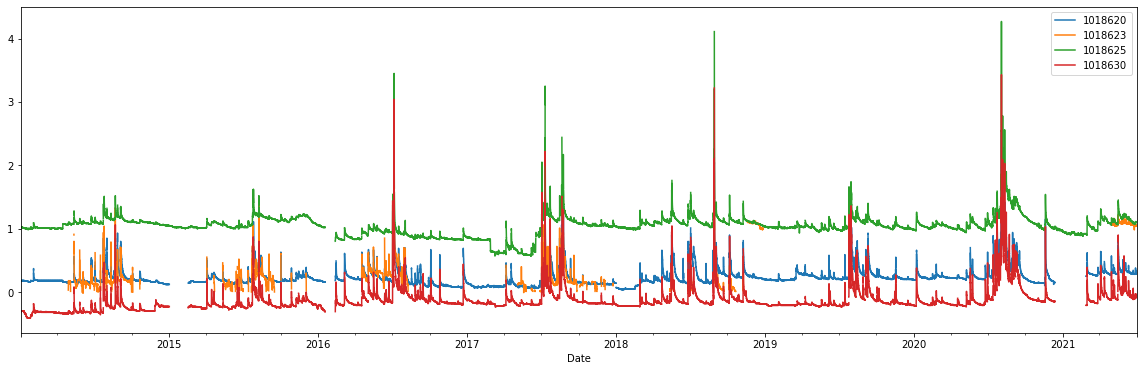

In [ ]:
df1 = df.drop(columns=['ymdh']).set_index('Date')
df1.plot(figsize=(20,6))

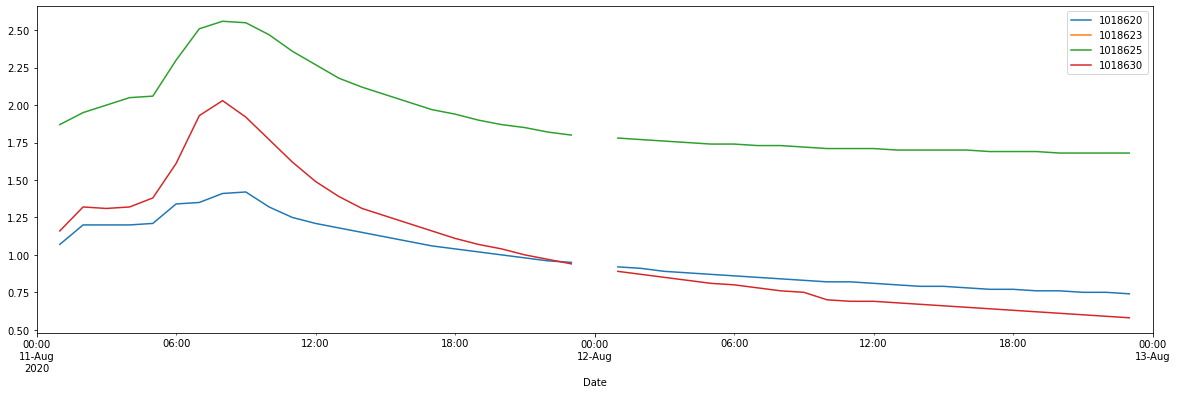

In [ ]:
df1 = df[(df['ymdh'] >= 2020081100) & (df['ymdh'] <= 2020081300)].drop(columns=['ymdh']).set_index('Date')
df1.plot(figsize=(20,6))